2025-04-15 12:23:59.400005: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-15 12:23:59.413517: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-15 12:23:59.417496: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-15 12:23:59.429917: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-15 12:24:00.108752: W tensorflow/compiler/tf2

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


/tmp/ipykernel_428507/645127640.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


(512, 512)
(512, 512)
(512, 512)
(512, 512)


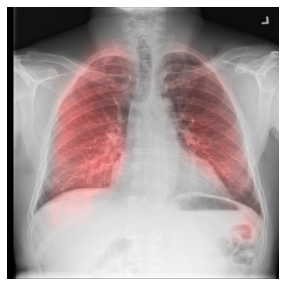

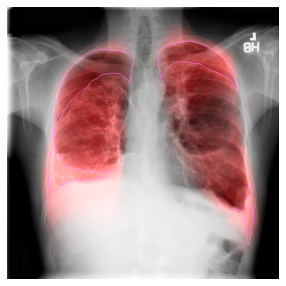

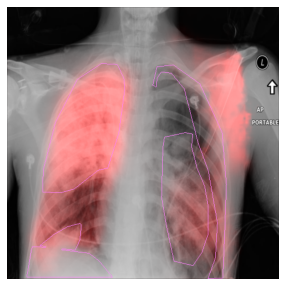

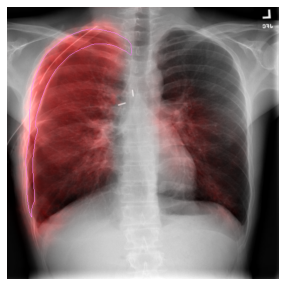

In [1]:
import os, sys, cv2, torch, random, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import random_split, DataLoader, ConcatDataset
import segmentation_models_pytorch as smp

seminar_path = Path("/home/alexskv/seminar_2")
sys.path.insert(0, str(seminar_path / "core"))

from dataset  import SimpleCocoDataset
from trainers import SimpleSegmentationTrainer
from losses   import BCELoss, FocalLoss, IoULoss, ComboLoss

device       = torch.device("cuda:1")
resize       = (512, 512)
batch_size   = 96
pathology_ids = [i for i in range(6, 27) if i != 15]
out_classes   = [{"id": 1, "name": "Патология", "summable_masks": pathology_ids, "subtractive_masks": []}]
base_names = [
    "Правое лёгкое", "Левое лёгкое", "Контуры сердца", "Купола диафрагмы и нижележащая область",
    "Сложный случай", "нельзя составить заключение", "Иная патология", "Гидроторакс",
    "Легочно-венозная гипертензия 2 стадии и выше", "Пневмоторакс", "Доброкачественное новообразование",
    "Перелом ребра свежий", "Буллезное вздутие, тонкостенная киста",
    "Рак лёгкого (включая дорожку к корню при наличии)", "Кардиомегалия (отмечается всё сердце, как патология)",
    "Интерстициальная пневмония.", "Метастатическое поражение лёгких", "Полость с уровнем жидкости",
    "Грыжа пищевого отверстия диафрагмы", "Спавшийся сегмент лёгкого при ателектазе", "Инфильтративный туберкулёз",
    "Пневмония. В том числе сегментарная и полисегментарная", "Область распада, деструкции тканей лёгкого",
    "Участок пневмофиброза", "Кальцинаты. Каждый кальцинат выделяется отдельным контуром",
    "Консолидированный перелом ребра"
]
base_classes = [{"id": i + 1, "name": n} for i, n in enumerate(base_names)]

data_roots = {p.parent.parent for p in (seminar_path / "data").rglob("annotations/instances_default.json")}
datasets   = [SimpleCocoDataset(str(d), base_classes, out_classes, resize=resize) for d in sorted(data_roots)]
full_ds    = ConcatDataset(datasets)
val_size   = int(0.2 * len(full_ds))
train_ds, val_ds = random_split(full_ds, [len(full_ds) - val_size, val_size])

model = smp.FPN(encoder_name="efficientnet-b0", encoder_weights=None, in_channels=1, classes=1)
model_path = "save_models/96085_Combo_loss_weight_NN_best.pth"
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device).eval()

n_examples = 4
idxs = random.sample(range(len(val_ds)), n_examples)

for idx in idxs:
    batch = val_ds[idx]
    img, mask =  batch["images"], batch["masks"][1:]
    
    with torch.no_grad():
        pred = torch.sigmoid(model(img.unsqueeze(0).to(device)))[0, 0].cpu().numpy()
    img_np = img.numpy()[0]
    base   = (img_np - img_np.min()) / (img_np.max() - img_np.min() + 1e-8)
    rgb    = np.stack([base, base, base], -1)
    rgb[..., 2] = np.clip(rgb[..., 2] + pred * 0.6, 0, 1)
    mask_np = (mask.numpy()[0] > 0.5).astype(np.uint8)
    print(np.shape(mask_np))
    contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rgb_uint8 = (rgb * 255).astype(np.uint8)
    cv2.drawContours(rgb_uint8, contours, -1, (255, 128, 255), 1)
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(rgb_uint8[..., ::-1])
plt.show()
